In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy.engine import URL
from sqlalchemy import create_engine
import pyodbc
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [110]:
server = 'DB06.petvetcarecenters.com' 
database = 'ReportingPV' 
username = 'PetVet_RW' 
password = 'p3tv3tc@r3c3nt3rs'  
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()

In [111]:
server = 'DB04.petvetcarecenters.com' 
database = 'DWPV' 
username = 'PetVet_RW' 
password = 'p3tv3tc@r3c3nt3rs'  
conn_str = (
    'DRIVER={SQL Server};'
    f'SERVER={server};'
    f'DATABASE={database};'
    f'UID={username};'
    f'PWD={password}'
)
# Establish the connection
conn = pyodbc.connect(conn_str)
query = """
SELECT DISTINCT
       li.Sku,
       li.SkuDescription,
       s.UnitOfMeasure,
       li.Quantity,
       li.NetRevenue,
       s.IsTaxable,
       li.Name,
       li.Species,
       li.Breed,
       li.Location_ID,
       s.MappingValue AS MasterClassification,
       ld.Location,
       ld.Location_Type,
       ld.Location_Name,
       ld.Location_Group,
       ld.Address_Line_1,
       ld.Address_Line_2,
       ld.City,
       ld.State,
       ld.Zip,
       ld.Acq_Date,
       ld.SqFt,
       ld.Closed,
       ld.PMS,
       ld.Region,
       ld.RegionalManager
--INTO #temp
FROM
(
    SELECT DISTINCT
           l.Location_ID,
           l.ClientID,
           l.PatientID,
           l.Sku,
           l.SkuDescription,
           --l.SkuUnitOfMeasure,
           l.Quantity,
           l.NetRevenue,
           p.Name,
           p.Species,
           p.Breed
    --p.Gender
    FROM Staging.LineItem l
        LEFT JOIN Staging.Patient p
            ON p.PatientID = l.PatientID
               AND p.Location_ID = l.Location_ID
               AND p.ClientID = l.ClientID
) li
    JOIN
    (
        SELECT DISTINCT
               s.Location_ID,
               s.Sku,
               cm.Name MappingValue,
               s.UnitOfMeasure,
               s.IsTaxable
        FROM Accounting.SkuV2 s
            LEFT JOIN Configuration.SkuMapping m
                ON m.Location_ID = s.Location_ID
                   AND m.Sku = s.Sku
            LEFT JOIN Reference.DropdownList c
                ON c.DropdownListId = m.DropDownListId
            LEFT JOIN Reference.DropdownListMember cm
                ON m.DropdownListMemberId = cm.DropdownListMemberId
        WHERE m.DropDownListId = 8
    ) s
        ON s.Location_ID = li.Location_ID
           AND s.Sku = li.Sku
    JOIN dbo.Location_Details ld
        ON ld.Location_ID = s.Location_ID
"""
# Execute the query and load the data into a DataFrame
df = pd.read_sql(query, conn)


# Close the connection
conn.close()


C:\Users\qallegue\AppData\Local\Temp\ipykernel_26172\452100367.py:88: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [85]:
train = df

In [86]:
train.head()

,Sku,SkuDescription,UnitOfMeasure,Quantity,NetRevenue,IsTaxable,Name,Species,Breed,Location_ID,...,Address_Line_2,City,State,Zip,Acq_Date,SqFt,Closed,PMS,Region,RegionalManager
0,#CON2,Convenia Injectable- 11-20 lbs,,1.0,93.0,None,Ferrari,Feline,Domestic Shorthair,262,...,None,Bedford Hills,NY,10507,2020-06-05,2400.0,0,Avimark,North East,"Rough, Jennifer"
1,*SA705*,XXX Antech Senior Feline 7 + Years,,-1.0,-123.5,None,Bliss,Feline,DOMESTIC LONG HAIR,228,...,None,Tumwater,WA,98512,2019-09-13,7560.0,0,Avimark,West,"Hesketh, Ryan"
2,*SA705*,XXX Antech Senior Feline 7 + Years,,1.0,0.0,None,Ash,Feline,Russian Blue Mix,228,...,None,Tumwater,WA,98512,2019-09-13,7560.0,0,Avimark,West,"Hesketh, Ryan"
3,*SA705*,XXX Antech Senior Feline 7 + Years,,1.0,123.5,None,Bliss,Feline,DOMESTIC LONG HAIR,228,...,None,Tumwater,WA,98512,2019-09-13,7560.0,0,Avimark,West,"Hesketh, Ryan"
4,*SA705*,XXX Antech Senior Feline 7 + Years,,1.0,247.0,None,Chopin,Feline,Dmh,228,...,None,Tumwater,WA,98512,2019-09-13,7560.0,0,Avimark,West,"Hesketh, Ryan"


<Axes: >

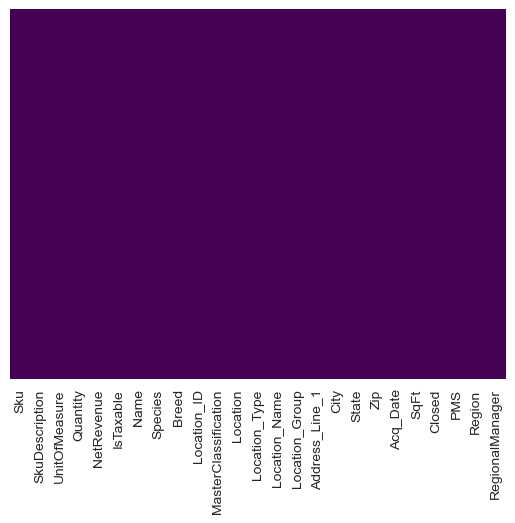

In [98]:
##handle missing data
sns.heatmap(train.isnull(), yticklabels = False, cbar = False, cmap = "viridis")

In [87]:
train.drop('Address_Line_2', axis = 1, inplace = True)

In [88]:
train['IsTaxable'].fillna(0, inplace = True)

C:\Users\qallegue\AppData\Local\Temp\ipykernel_26172\2626915640.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['IsTaxable'].fillna(0, inplace = True)
C:\Users\qallegue\AppData\Local\Temp\ipykernel_26172\2626915640.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['IsTaxable'].fillna(0, inplac

<Axes: xlabel='Location_Type', ylabel='SqFt'>

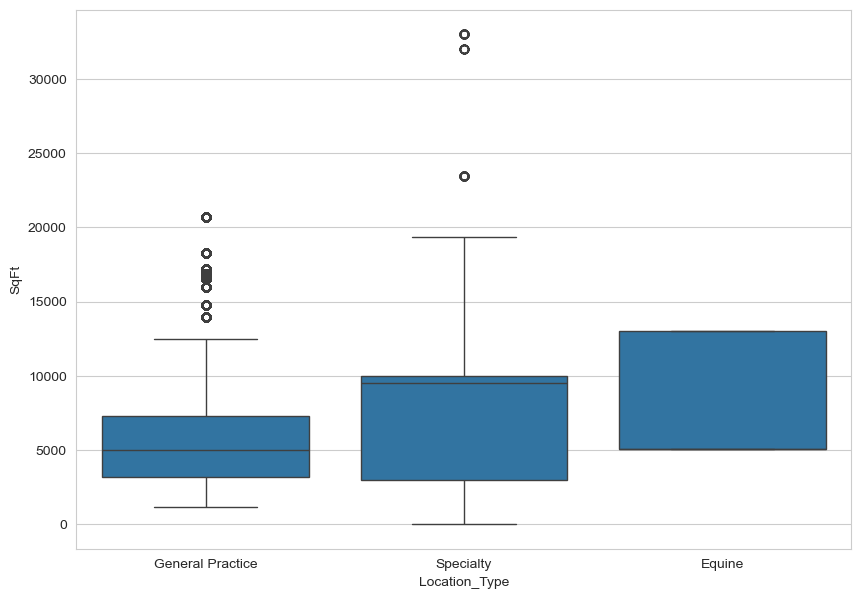

In [89]:
## Analyse relationship between SqFt and Location_Type
plt.figure(figsize=(10,7))
sns.boxplot(x = 'Location_Type', y = 'SqFt', data = train)

In [95]:
# Fill null values in 'SqFt' column with the mean value based on 'Location_Type'
df['SqFt'] = df.groupby('Location_Type')['SqFt'].transform(lambda x: x.fillna(x.mean())) # Approximate null SqFt with average by Location_Type

In [93]:
train.dropna(subset=['SkuDescription'], inplace= True) # Prefiction relies on SkuDescription

In [92]:
train.dropna(subset=['Region'], inplace = True) ## All locs without region or regional manager assigned are closed

In [97]:
## Create new category 'Unknown' for patient info 
df['Species'].fillna('Unknown', inplace=True)
df['Breed'].fillna('Unknown', inplace=True)
df['Name'].fillna('Unknown', inplace=True)

C:\Users\qallegue\AppData\Local\Temp\ipykernel_26172\1367987782.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Species'].fillna('Unknown', inplace=True)
C:\Users\qallegue\AppData\Local\Temp\ipykernel_26172\1367987782.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 

<Axes: >

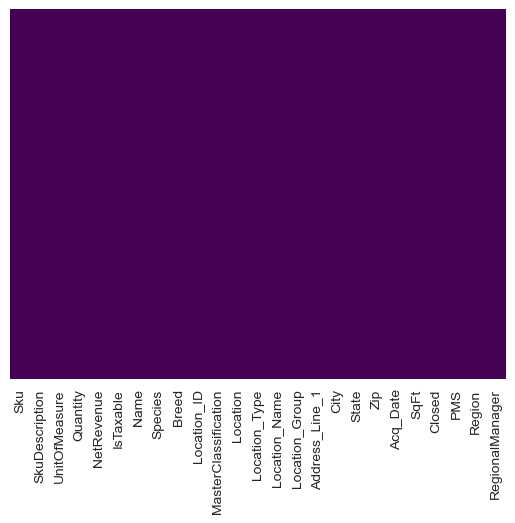

In [99]:
## No more missing data
sns.heatmap(train.isnull(), yticklabels = False, cbar = False, cmap = "viridis")

In [100]:
pip install nltk

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 11.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [101]:
import nltk

In [103]:
nltk.download_shell()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------


Downloader>  Download


Command 'Download' unrecognized

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------


Downloader>  stopwords


Command 'stopwords' unrecognized

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------


Downloader>  d



Download which package (l=list; x=cancel)?


  Identifier>  stopwords


        C:\Users\qallegue\AppData\Roaming\nltk_data...
      Unzipping corpora\stopwords.zip.



---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------


Downloader>  d



Download which package (l=list; x=cancel)?


  Identifier>  l


Packages:
  [ ] abc................. Australian Broadcasting Commission 2006
  [ ] alpino.............. Alpino Dutch Treebank
  [ ] averaged_perceptron_tagger Averaged Perceptron Tagger
  [ ] averaged_perceptron_tagger_eng Averaged Perceptron Tagger (JSON)
  [ ] averaged_perceptron_tagger_ru Averaged Perceptron Tagger (Russian)
  [ ] averaged_perceptron_tagger_rus Averaged Perceptron Tagger (Russian)
  [ ] basque_grammars..... Grammars for Basque
  [ ] bcp47............... BCP-47 Language Tags
  [ ] biocreative_ppi..... BioCreAtIvE (Critical Assessment of Information
                           Extraction Systems in Biology)
  [ ] bllip_wsj_no_aux.... BLLIP Parser: WSJ Model
  [ ] book_grammars....... Grammars from NLTK Book
  [ ] brown............... Brown Corpus
  [ ] brown_tei........... Brown Corpus (TEI XML Version)
  [ ] cess_cat............ CESS-CAT Treebank
  [ ] cess_esp............ CESS-ESP Treebank
  [ ] chat80.............. Chat-80 Data Files
  [ ] city_database....... City 

Hit Enter to continue:  q



Download which package (l=list; x=cancel)?


  Identifier>  stopwords


        C:\Users\qallegue\AppData\Roaming\nltk_data...
      Package stopwords is already up-to-date!



---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------


Downloader>  q


In [105]:
desc = [line.strip() for line in train['SkuDescription']]

In [108]:
for desc_no, desc in enumerate(desc[:10]):
    print(desc_no, desc)
    print('\n')

0 Convenia Injectable- 11-20 lbs


1 XXX Antech Senior Feline 7 + Years


2 XXX Antech Senior Feline 7 + Years


3 XXX Antech Senior Feline 7 + Years


4 XXX Antech Senior Feline 7 + Years


5 XXX Antech Senior Feline 7 + Years


6 XXX Antech Senior Feline 7 + Years


7 XXX Antech Senior Feline 7 + Years


8 XXX Antech Senior Feline 7 + Years


9 Doxycycline 100mg Tablets


